In [7]:
using Images
using ImageView
using Interpolations
# set data dir
main_dir = "/Users/colin/Dropbox/__Atlas__/"
data_dir = "/Users/colin/Dropbox/__Atlas__/data"
# get list of subject folders
cd(data_dir)
sub_dirs = filter(x->isdir(x),readdir(data_dir))

## Subject loop starts here
s = 1
# cd into subfolders
cd(abspath(joinpath(sub_dirs[1],"histology/")))
# get image names
imgnames = filter(x->contains(x,".tif"), readdir())

INFO: Recompiling stale cache file /Users/colin/.julia/lib/v0.5/Ratios.ji for module Ratios.
INFO: Recompiling stale cache file /Users/colin/.julia/lib/v0.5/Interpolations.ji for module Interpolations.


77-element Array{String,1}:
 "crsSlice001.tiff"
 "crsSlice002.tiff"
 "crsSlice003.tiff"
 "crsSlice004.tiff"
 "crsSlice005.tiff"
 "crsSlice006.tiff"
 "crsSlice007.tiff"
 "crsSlice008.tiff"
 "crsSlice009.tiff"
 "crsSlice010.tiff"
 "crsSlice011.tiff"
 "crsSlice012.tiff"
 "crsSlice013.tiff"
 ⋮                 
 "crsSlice067.tiff"
 "crsSlice068.tiff"
 "crsSlice069.tiff"
 "crsSlice070.tiff"
 "crsSlice071.tiff"
 "crsSlice072.tiff"
 "crsSlice073.tiff"
 "crsSlice074.tiff"
 "crsSlice075.tiff"
 "crsSlice076.tiff"
 "crsSlice077.tiff"
 "crsSlice078.tiff"

In [127]:
fixi = 1
movi = 2
# load images
#fixed = separate(load(imgnames[fixi]))
fixed = load(imgnames[fixi])
fixed = float64(fixed)
typeof(fixed)

Images.Image{ColorTypes.Gray{Float64},2,Array{ColorTypes.Gray{Float64},2}}

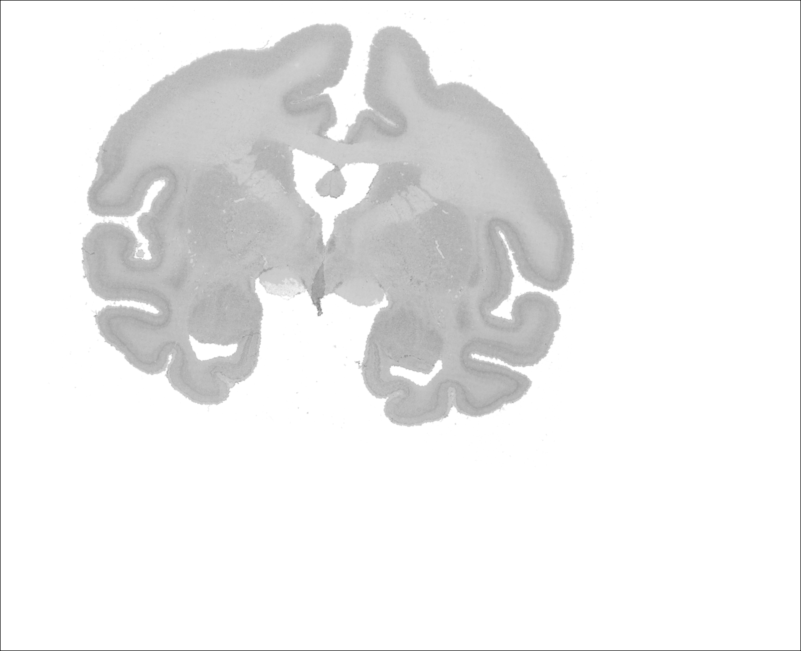

In [37]:
## rotation
degree = 10.0
rotated = deepcopy(fixed)
midx = size(fixed,1)/2
midy = size(fixed,2)/2
rotated .= 1
# rotate image
angle = degree*pi/180.0
#pre allocate dimensions
# calc rotation
for i in 1:size(fixed,1)
    #i=2
    #j=1
    for j in 1:size(fixed,2)
        x = (i-midx)*cos(angle) + (j-midy)*sin(angle) +midx
        y = -(i-midx)*sin(angle) + (j-midy)*cos(angle) +midy
        if floor(x)>0 && floor(y) >0 && ceil(x)<=size(fixed,1) && ceil(y)<=size(fixed,2)
            hx = Int64(ceil(x))
            lx = Int64(floor(x))
            hy = Int64(ceil(y))
            ly = Int64(floor(y))
            #MAP interpolated rotation
            A = [(1-(x-lx)) * (1-(y-ly)) (x-lx)*(1-(y-ly)) (1-(x-lx))*(y-ly) (x-lx)*(y-ly)]
            rotated.data[i,j] = A[1]*fixed.data[lx,ly] +
                A[2]*fixed.data[hx,ly] +
                A[3]*fixed.data[lx,hy] +
                A[4]*fixed.data[hx,hy]
            #rotated.data[i,j] = fixed.data[Int64(round(x)),Int64(round(y))]
        end
    end
end
rotated

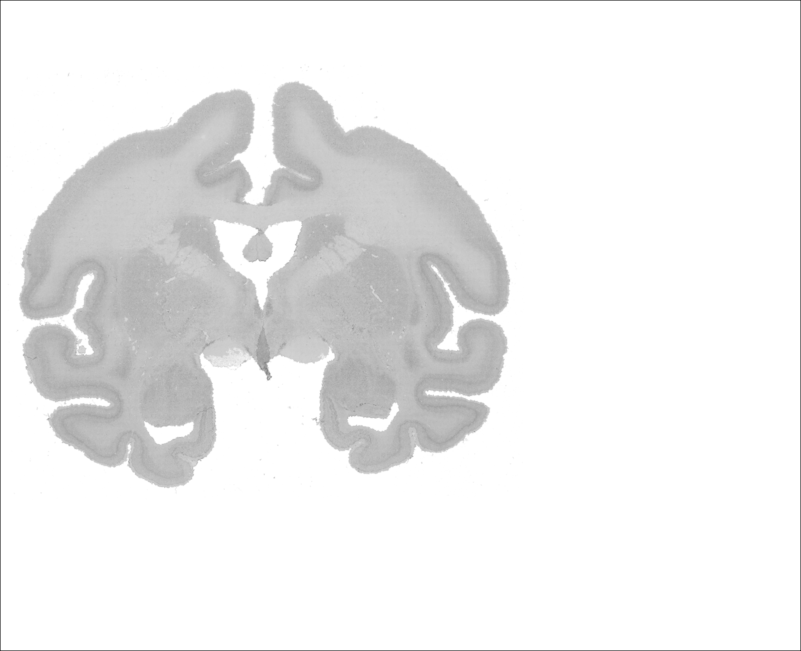

In [38]:
## translation
translated = copy(fixed)
trans = [-100,100]
translated = circshift(translated,trans)


In [143]:
function imtransform(image::Images.Image{ColorTypes.Gray{Float64},2,Array{ColorTypes.Gray{Float64},2}}; degree::Float64=0.0, trans::Array{Int64,1}=[0,0], bg::Float64 = 1.0)
    function rotate(image::Images.Image{ColorTypes.Gray{Float64},2,Array{ColorTypes.Gray{Float64},2}},moving::Images.Image{ColorTypes.Gray{Float64},2,Array{ColorTypes.Gray{Float64},2}},degree::Float64,bg::Float64)
        moving .= bg
        midx::Float64 = size(image,1)/2
        midy::Float64 = size(image,2)/2
        # rotate image
        angle::Float64 = degree*pi/180.0
        ca::Float64 = cos(angle)
        sa::Float64 = sin(angle)
        
        nx::Int64 = size(moving,1)
        ny::Int64 = size(moving,2)
        @fastmath @inbounds for i in 1:nx
            for j in 1:ny
                x::Float64 = (i-midx)*ca + (j-midy)*sa +midx
                y::Float64 = -(i-midx)*sa + (j-midy)*ca +midy
                if (floor(x)>0 && floor(y) >0 && x<=nx && y<=ny)::Bool
                    #moving.data[i,j] = image.data[Int64(round(x)),Int64(round(y))]
                    lx::Float64 = floor(x)
                    ly::Float64 = floor(y)
                    #MAP interpolated rotation
                    moving.data[i,j] = ((1-(x-lx))*(1-(y-ly))*image.data[Int64(lx),Int64(ly)] +
                                    (x-lx)*(1-(y-ly))*image.data[Int64(lx)+1,Int64(ly)] +
                                    (1-(x-lx))*(y-ly)*image.data[Int64(lx),Int64(ly)+1] +
                                    (x-lx)*(y-ly)*image.data[Int64(lx)+1,Int64(ly)+1])::ColorTypes.Gray{Float64}
                end
            end
        end
        return moving::Images.Image{ColorTypes.Gray{Float64},2,Array{ColorTypes.Gray{Float64},2}}
    end
    function translate(moving,trans)
        moving = circshift(moving,trans)
        return moving::Images.Image{ColorTypes.Gray{Float64},2,Array{ColorTypes.Gray{Float64},2}}
    end
    
    
    moving::Images.Image{ColorTypes.Gray{Float64},2,Array{ColorTypes.Gray{Float64},2}} = copy(image)
    if degree != 0
        moving = rotate(image,moving,degree,bg)
    end
    if trans != [0,0]
        moving = translate(moving,trans)
    end
    return moving
end

@code_warntype imtransform(fixed,degree=-30.0,trans=[100,-30],bg=1.0)

Variables:
  #unused#::#kw##imtransform
  #temp#@_2::Array{Any,1}
  ::#imtransform
  image::Images.Image{ColorTypes.Gray{Float64},2,Array{ColorTypes.Gray{Float64},2}}
  degree::Float64
  #temp#@_6::Bool
  bg::Float64
  trans::Array{Int64,1}
  #temp#@_9::Int64
  #temp#@_10::Int64
  #temp#@_11::Int64
  #temp#@_12::Any

Body:
  begin 
      NewvarNode(:(trans::Array{Int64,1}))
      degree::Float64 = 0.0
      #temp#@_6::Bool = true
      bg::Float64 = 1.0
      SSAValue(2) = (Base.arraylen)(#temp#@_2::Array{Any,1})::Int64
      SSAValue(3) = (Base.select_value)((Base.sle_int)(0,1)::Bool,(Base.box)(Int64,(Base.ashr_int)(SSAValue(2),(Base.box)(UInt64,1))),(Base.box)(Int64,(Base.shl_int)(SSAValue(2),(Base.box)(UInt64,(Base.box)(Int64,(Base.neg_int)(1))))))::Int64
      SSAValue(5) = (Base.select_value)((Base.sle_int)(1,SSAValue(3))::Bool,SSAValue(3),(Base.box)(Int64,(Base.sub_int)(1,1)))::Int64
      #temp#@_9::Int64 = 1
      9: 
      unless (Base.box)(Base.Bool,(Base.not_int)((#temp#@_9:

  0.174537 seconds (39.58 k allocations: 1.392 MB)


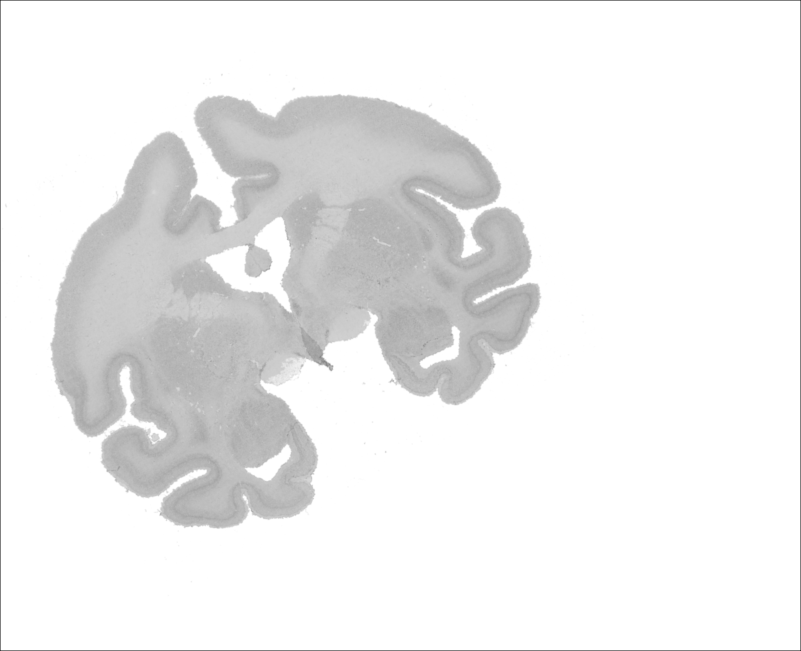

In [55]:
function rotate(image,moving,degree,bg)
    moving .= bg
    midx = size(image,1)/2
    midy = size(image,2)/2
    # rotate image
    angle = degree*pi/180.0
    for i in 1:size(moving,1)
        for j in 1:size(moving,2)
            x = (i-midx)*cos(angle) + (j-midy)*sin(angle) +midx
            y = -(i-midx)*sin(angle) + (j-midy)*cos(angle) +midy
            if floor(x)>0 && floor(y) >0 && ceil(x)<=size(moving,1) && ceil(y)<=size(moving,2)
                #moving.data[i,j] = image.data[Int64(round(x)),Int64(round(y))]
                hx = ceil(x)
                lx = floor(x)
                hy = ceil(y)
                ly = floor(y)
                #MAP interpolated rotation
                moving.data[i,j] = (1-(x-lx))*(1-(y-ly))*image.data[Int64(lx),Int64(ly)] +
                                   (x-lx)*(1-(y-ly))*image.data[Int64(hx),Int64(ly)] +
                                   (1-(x-lx))*(y-ly)*image.data[Int64(lx),Int64(hy)] +
                                   (x-lx)*(y-ly)*image.data[Int64(hx),Int64(hy)]
            end
        end
    end
    return moving
end
moving = copy(fixed)
@time rotate(fixed,moving,-30,1)

In [5]:
Pkg.update()

INFO: Updating METADATA...
INFO: Updating cache of URIParser...
INFO: Updating cache of LineSearches...
INFO: Updating cache of DataFrames...
INFO: Updating cache of Compat...
INFO: Updating cache of JSON...
INFO: Updating cache of DataFrames...
INFO: Updating TimeZones master... da3d434b → 5d595fa7
INFO: Updating NLopt master...
INFO: Computing changes...
INFO: Upgrading Compat: v0.11.0 => v0.12.0
INFO: Upgrading JSON: v0.8.0 => v0.8.1
INFO: Upgrading LineSearches: v0.1.3 => v0.1.4
INFO: Upgrading URIParser: v0.1.6 => v0.1.7


In [20]:
A = rand(5,5)
A_x = collect(1.0:1.0:5.0)
A_y = collect(1.0:1.0:5.0)
knots = (A_x,A_y)
itp = interpolate(knots, A, Gridded(Linear()))
print(A)
itp[1.0,1.1] 

[0.674377 0.888622 0.25837 0.104097 0.917905; 0.291405 0.831218 0.898286 0.220798 0.029196; 0.115177 0.154758 0.972114 0.217624 0.00449764; 0.186064 0.775772 0.549304 0.816353 0.633681; 0.790449 0.936375 0.532798 0.712697 0.840795]

0.6958019267776884

In [21]:
typeof(itp)

Interpolations.GriddedInterpolation{Float64,2,Float64,Interpolations.Gridded{Interpolations.Linear},Tuple{Array{Float64,1},Array{Float64,1}},0}